A lot of this notebook with summarize Christoph Molnar's book, 
[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/).
I highly recommend reading it in full if you haven't!

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 4)


'''
California Housing dataset
--------------------------
Features:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surprisingly large values for block groups with few households
and many empty houses, such as vacation resorts.
'''
housing = fetch_california_housing()
# print(housing['DESCR'])
housing_df = pd.DataFrame(housing['data'], columns=housing['feature_names'])
housing_df['y'] = housing['target']
housing_df.rename(columns={
    'MedInc': 'median_income',
    'HouseAge': 'median_house_age',
    'AveRooms': 'avg_rooms',
    'AveBedrms': 'avg_bedrooms',
    'Population': 'population',
    'AveOccup': 'avg_occup',
    'Latitude': 'lat',
    'Longitude': 'lon',
    'Target': 'target'
}, inplace=True)
# housing_df.info()
housing_df

,median_income,median_house_age,avg_rooms,avg_bedrooms,population,avg_occup,lat,lon,y
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


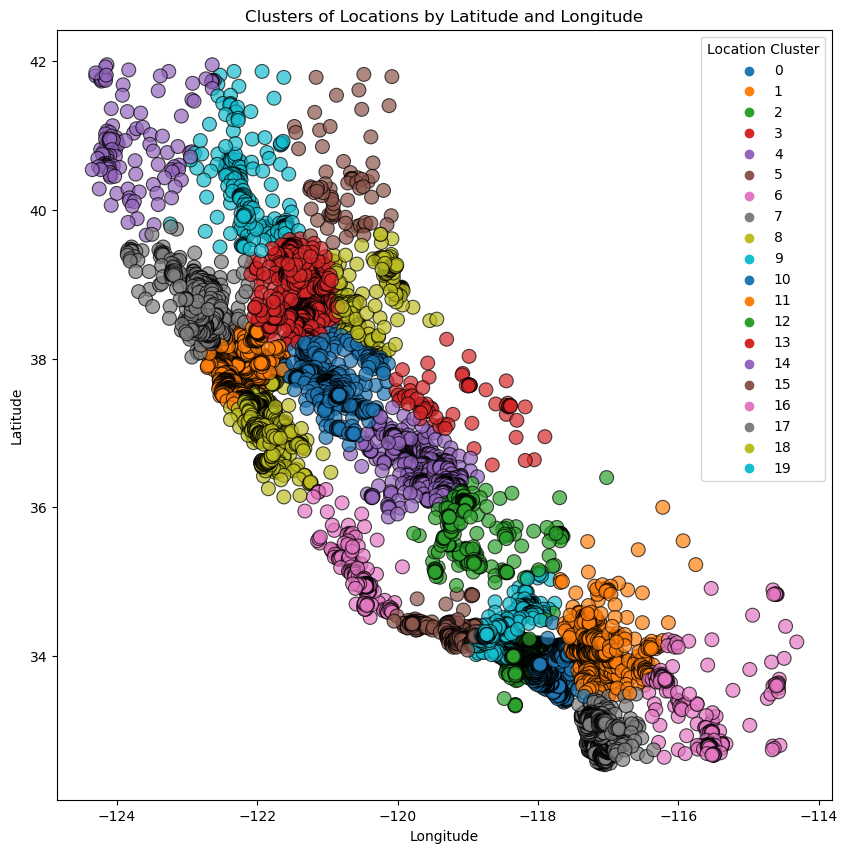

In [91]:
# results =[]
# for i in range(1, 10):
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(housing_df[['lat', 'lon']])
#     results.append(kmeans.inertia_)

# plt.plot([i for i in range(1, 10)], results, marker='o')
# plt.show()

kmeans = KMeans(n_clusters=20, random_state=0).fit(housing_df[['lat', 'lon']])
housing_df['location_cluster'] = kmeans.fit_predict(housing_df[['lat', 'lon']])
housing_df['location_cluster'] = housing_df['location_cluster'].astype('category')

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x='lon',
    y='lat',
    hue='location_cluster',
    palette='tab10',
    data=housing_df,
    s=100,
    alpha=0.7,
    edgecolor='black'
)
plt.title('Clusters of Locations by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Location Cluster')
plt.show()

## Linear Regression
"I argue that you cannot really imagine a linear model with 5 features, because it would mean drawing the estimated hyperplane mentally in a 5-dimensional space. Any feature space with more than 3 dimensions is simply inconceivable for humans. Usually, when people try to comprehend a model, they consider only parts of it, such as the weights in linear models" 
[[1](https://christophm.github.io/interpretable-ml-book/scope-of-interpretability.html)].

All the interpretations always come with the footnote that "all other features remain the same". The estimated linear equation is a hyperplane in the feature/target space. The interpretation ignores the joint distribution of the features. Increasing one feature, but not changing another, can lead to unrealistic or at least unlikely data points [[1](https://christophm.github.io/interpretable-ml-book/limo.html)].

For example, switching location_clusters, but not latitude of longitude.

R-squared is a measure of how much of the variance of your target outcome is explained by the model. 
$$ R^2 = 1 - \frac{\text{Sum of Squared Errors}}{\text{Total Sum of Squares}} $$

Even better, Adjusted R-squared accounts for the number of features used in the model.
$$ \text{Adjusted } R^2 = 1 - (1-R^2) \frac{n-1}{n-p-1} $$

The t-statistic of a coefficient is found with:
<!-- $$ t_\beta^t_j $$ -->
<!-- $$ t_{\hat{\beta}}_j =  $$ -->
$$ \frac{\text{Estimated Coefficient}}{\text{Standard Error}({\text{True Coefficient}})} $$ 

Standard Error (SE) is the standard deviation of the sampling distribution of a statistic. It measures how much the estimated statistic (e.g., sample mean, regression coefficient) is expected to vary from sample to sample due to random sampling variability. Standard error is used to construct confidence intervals around an estimate to indicate the range within which the true population parameter is likely to lie.
$$ 95\% \text{ Confidence Interval:} = \text{Estimate} ± (Z×SE) $$

Z is the Z-score corresponding to the desired confidence level (1.96 for 95%)

In [122]:
model = sm.OLS(housing_df['y'], housing_df.drop('y', axis=1)).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                          1.901e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                        0.00
Time:                        22:28:35   Log-Likelihood:                         -24077.
No. Observations:               20640   AIC:                                  4.817e+04
Df Residuals:                   20631   BIC:                                  4.824e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [123]:
housing_df.iloc[:2]#.drop('y', axis=1)

,median_income,median_house_age,avg_rooms,avg_bedrooms,population,avg_occup,lat,lon,y,location_cluster
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526,1
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585,1


In [124]:
model.predict(housing_df.iloc[:2].drop('y', axis=1))

0    4.078903
1    3.865848
dtype: float64

Weight plots visualize the range of the estimated coefficients.

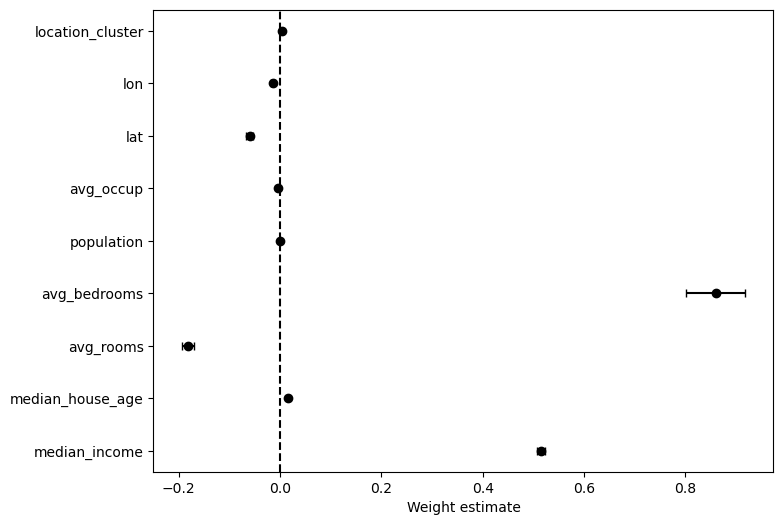

In [96]:
coef = model.params
conf = model.conf_int()
conf['coef'] = coef

# Plotting similar to the image provided
fig, ax = plt.subplots(figsize=(8, 6))

# Variables for plotting
var_names = conf.index
coef_vals = conf['coef'].values
error_bars = [(conf[1][i] - conf[0][i]) / 2 for i in range(len(conf))]

ax.errorbar(coef_vals, var_names, xerr=error_bars, fmt='o', color='black', ecolor='black', capsize=3)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Weight estimate')
ax.set_ylabel('')

plt.show()

Effect plots look at the weight per feature * the feature value to help visualize how much the combination contributes to the prediction.

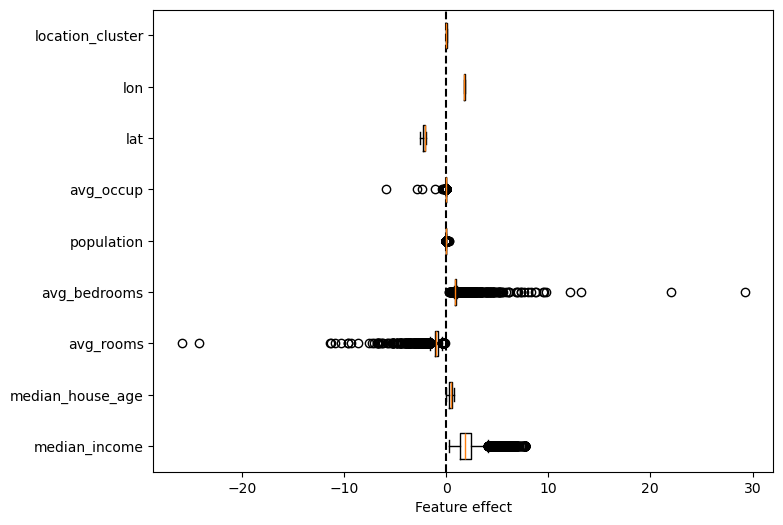

In [80]:
feature_effects = {
    feature: (housing_df[feature] * model.params[feature]).to_numpy() for feature in var_names
}

fig, ax = plt.subplots(figsize=(8, 6))

# Plotting boxplots for each feature
ax.boxplot([feature_effects[feature] for feature in var_names], vert=False, patch_artist=False)
ax.set_yticklabels(var_names)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Feature effect')

plt.show()

Now scaling the data, and adding a constant term.

In [135]:
from sklearn.preprocessing import StandardScaler

X = housing_df.drop('y', axis=1)  # Features (independent variables)
y = housing_df['y']  # Target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:39:08   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0686      0.005    410.326      0.0

In [136]:
housing_df.iloc[:2]

,median_income,median_house_age,avg_rooms,avg_bedrooms,population,avg_occup,lat,lon,y
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


In [137]:
model.predict(X_scaled[:2, :])

array([4.13164983, 3.97660644])

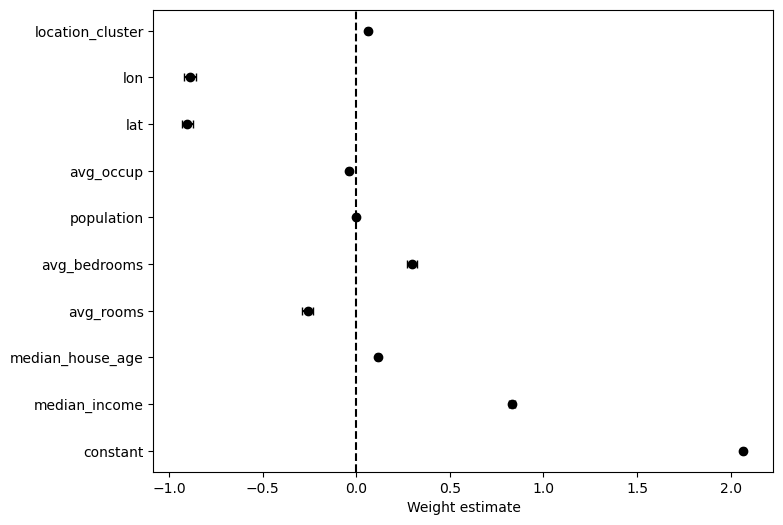

In [110]:
coef = model.params
conf = model.conf_int()
conf['coef'] = coef

# Plotting similar to the image provided
fig, ax = plt.subplots(figsize=(8, 6))

# Variables for plotting
var_names = ['constant'] + X.columns.to_list()#conf.index
coef_vals = conf['coef'].values
error_bars = [(conf[1][i] - conf[0][i]) / 2 for i in range(len(conf))]

ax.errorbar(coef_vals, var_names, xerr=error_bars, fmt='o', color='black', ecolor='black', capsize=3)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Weight estimate')
ax.set_ylabel('')

plt.show()

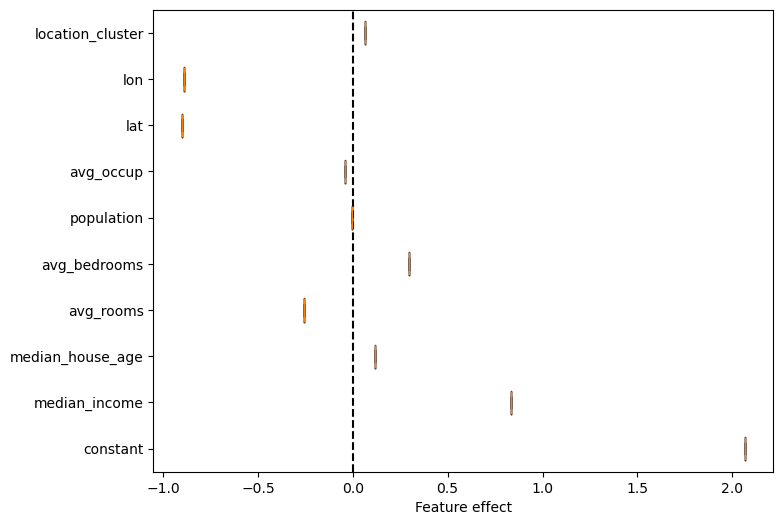

In [116]:
for i in range(0, len(var_names)):
    feature_effects[var_names[i]] = (X_scaled[:, 0] * model.params[i])

fig, ax = plt.subplots(figsize=(8, 6))

# Plotting boxplots for each feature
ax.boxplot([feature_effects[feature] for feature in var_names], vert=False, patch_artist=False)
ax.set_yticklabels(var_names)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Feature effect')

plt.show()

## Logistic Regression